In [1]:
from tools import *
plt.ion()
from matplotlib import patches, lines, text
d = load_data()
%config InlineBackend.figure_format = 'retina'

In [14]:
def find_mag_ang(x, z):
    mag = np.sqrt(x**2 + z**2)
    arctan = np.arctan(z/x) * 180 / np.pi
    arcsin = np.arcsin(z/mag) * 180 / np.pi
    arccos = np.arccos(x/mag) * 180 / np.pi
    
    if x > 0 and z > 0:
        ang = np.arctan(z/x) * 180/np.pi
    elif x < 0 and z > 0:
        ang = 180 + np.arctan(z/x) * 180/np.pi
    elif x < 0 and z < 0:
        ang = 180 + np.arctan(z/x) * 180/np.pi
    elif x > 0 and z < 0:
        ang = 2 * 180 + np.arctan(z/x) * 180/np.pi
    
    return(mag, ang, arctan, arcsin, arccos)

In [41]:
trial = d['P11']['trials']['t41']

print trial['name']
x = trial['index8x'][-1] - trial['objectx'][-1]
z = trial['index8z'][-1] - trial['objectz'][-1] - 0.02
mag, ang, arctan, arcsin, arccos = find_mag_ang(x, z)

print 'Magnitude = {}'.format(mag)
print 'Angle     = {}'.format(ang)
print '-----'
print 'arctan(t) = {}'.format(arctan)
print 'arcsin(t) = {}'.format(arcsin)
print 'arccos(t) = {}'.format(arccos)


Roman_Visible_NoCue_LeftToRight0004
Magnitude = 0.0239439997703
Angle     = 157.585373337
-----
arctan(t) = -22.4146266632
arcsin(t) = 22.4146266632
arccos(t) = 157.585373337


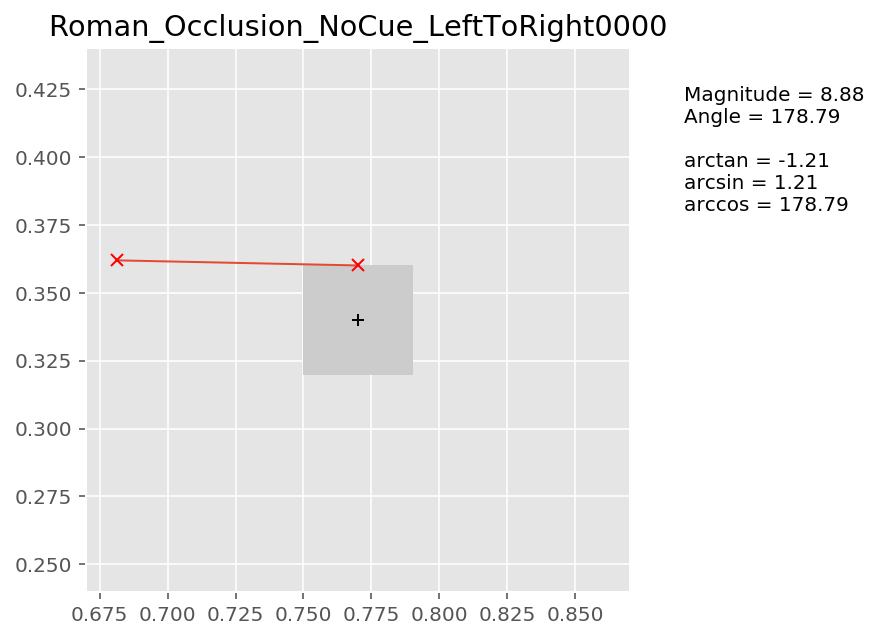

In [40]:
style.use('ggplot')
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)

ind_x = trial['index8x'][-1]
ind_z = trial['index8z'][-1]
obj_x = trial['objectx'][-1]
obj_z = trial['objectz'][-1]

xl, xr = obj_x - 0.1, obj_x + 0.1
yb, yt = obj_z - 0.1, obj_z + 0.1
asp = (xr - xl) / (yt - yb)

ax1.add_patch(patches.Rectangle( (obj_x - 0.02, obj_z - 0.02), 0.04, 0.04, color = [0.8, 0.8, 0.8]) )
ax1.add_line(lines.Line2D([ind_x, obj_x], [ind_z, obj_z + 0.02], linewidth = 1))
ax1.plot(ind_x, ind_z, 'rx')
ax1.plot(obj_x, obj_z + 0.02, 'rx')
ax1.plot(obj_x, obj_z,'k+')

ax1.set_xlim(xl, xr)
ax1.set_ylim(yb, yt)
ax1.set_aspect(asp)
ax1.set_title(trial['name'])
ax1.text(xr + 0.02, yt - 0.06, 'Magnitude = {}\nAngle = {}\n\narctan = {}\narcsin = {}\narccos = {}'\
         .format(np.round(mag, 4)*100, np.round(ang, 2), np.round(arctan, 2), np.round(arcsin, 2), np.round(arccos, 2)))